In [1]:
!pip install pyspellchecker language-tool-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 61.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.6 MB/s eta 0:00:00


In [2]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
Number of GPUs: 2
GPU 0: Tesla T4
GPU 1: Tesla T4


In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Set style for plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)

In [5]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
augmented_full_df = pd.read_csv('/kaggle/input/25k-essays/complete_essay_dataset.csv')
train_df, val_df = train_test_split(augmented_full_df, 
                                    test_size=0.25, 
                                    stratify=augmented_full_df['score'], 
                                    random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print("\nScore distribution in training set:")
print(train_df['score'].value_counts(normalize=True).sort_index())
print("\nScore distribution in validation set:")
print(val_df['score'].value_counts(normalize=True).sort_index())

Training set size: 18764
Validation set size: 6255

Score distribution in training set:
score
1    0.130143
2    0.188766
3    0.209017
4    0.156949
5    0.163611
6    0.151514
Name: proportion, dtype: float64

Score distribution in validation set:
score
1    0.130136
2    0.188809
3    0.209113
4    0.156835
5    0.163709
6    0.151399
Name: proportion, dtype: float64


In [7]:
# Custom Dataset class for essays
class EssayDataset(Dataset):
    def __init__(self, texts, scores, tokenizer, max_length=512):  # RoBERTa's max length
        self.texts = texts
        self.scores = scores - 1  # Convert to 0-indexed
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        score = self.scores[idx]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(score, dtype=torch.long)
        }

In [8]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig

# Set up tokenizer and model
model_name = "roberta-base"

# Define the configuration with custom dropout
config = RobertaConfig.from_pretrained(
    model_name,
    num_labels=6,  # Scores 1-6
    hidden_dropout_prob=0.1,  
    attention_probs_dropout_prob=0.1
)

tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    config=config  # Pass the custom config
)

# Wrap model with DataParallel for multi-GPU if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.to(device)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs!


DataParallel(
  (module): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dens

In [9]:
# Create datasets
train_dataset = EssayDataset(
    train_df['full_text'].values,
    train_df['score'].values,
    tokenizer
)

val_dataset = EssayDataset(
    val_df['full_text'].values,
    val_df['score'].values,
    tokenizer
)

In [10]:
# Calculate class weights for loss
train_labels = train_df['score'].values - 1
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [11]:
# Create data loaders
batch_size = 64 
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [12]:
# Training configuration
num_epochs = 4
lr = 2e-5  
warmup_steps = int(0.1 * len(train_loader) * num_epochs)
total_steps = len(train_loader) * num_epochs

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.1)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
# Training function
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device):
    best_val_qwk = 0
    patience = 3
    epochs_no_improve = 0
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    val_qwk_scores = []
    
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        model.train()
        epoch_train_loss = 0
        all_train_preds = []
        all_train_labels = []

       
        
        train_progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=True)
        for batch in train_progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            epoch_train_loss += loss.item()
            
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            all_train_preds.extend(batch_preds)
            all_train_labels.extend(labels.cpu().numpy())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            train_progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0
        predictions = []
        true_labels = []
        
        val_progress_bar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=True)
        with torch.no_grad():
            for batch in val_progress_bar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs.logits, labels)
                val_loss += loss.item()
                
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                predictions.extend(preds)
                true_labels.extend(labels.cpu().numpy())
                
                val_progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = accuracy_score(true_labels, predictions)
        val_qwk = cohen_kappa_score(true_labels, predictions, weights='quadratic')
        
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        val_qwk_scores.append(val_qwk)

        print(f"Average training loss: {avg_train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Train-Val Accuracy Gap: {train_accuracy - val_accuracy:.4f}")
        print(f"Validation QWK Score: {val_qwk:.4f}")
        
        print("\nDetailed Classification Report:")
        print(classification_report(
            true_labels, predictions, target_names=[f"Score {i+1}" for i in range(6)], digits=4
        ))
        
        if val_qwk > best_val_qwk:
            best_val_qwk = val_qwk
            torch.save(model.state_dict(), 'best_roberta_model.pt')
            epochs_no_improve = 0
            print("Saved best model!")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epochs_no_improve} epochs with no improvement!")
                return model  # Exit early

        
        print("-" * 50)
    
    plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies, val_qwk_scores)
    return model

In [14]:
# Plotting function
def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies, val_qwk_scores):
    if not train_losses:
        print("No metrics to plot due to early stopping or error.")
        return
    epochs = range(1, len(train_losses) + 1)
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    axs[0, 0].plot(epochs, train_losses, 'b-', label='Training Loss')
    axs[0, 0].plot(epochs, val_losses, 'r-', label='Validation Loss')
    axs[0, 0].set_title('Training and Validation Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    
    axs[0, 1].plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    axs[0, 1].plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    axs[0, 1].set_title('Training and Validation Accuracy')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()
    
    axs[1, 0].plot(epochs, val_qwk_scores, 'g-', label='Validation QWK Score')
    axs[1, 0].set_title('Validation QWK Score')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('QWK Score')
    axs[1, 0].legend()
    
    axs[1, 1].scatter(train_losses, val_losses, c=epochs, cmap='viridis', s=100)
    axs[1, 1].set_title('Training vs Validation Loss')
    axs[1, 1].set_xlabel('Training Loss')
    axs[1, 1].set_ylabel('Validation Loss')
    
    plt.tight_layout()
    plt.savefig('training_metrics_roberta.png')
    plt.show()
    
    print("Training metrics visualization saved to 'training_metrics_roberta.png'")

Epoch 1/4
--------------------------------------------------


Training Epoch 1:   0%|          | 0/294 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/98 [00:00<?, ?it/s]

Average training loss: 1.1087
Training accuracy: 0.5126
Validation Loss: 0.7569
Validation Accuracy: 0.6788
Train-Val Accuracy Gap: -0.1662
Validation QWK Score: 0.9182

Detailed Classification Report:
              precision    recall  f1-score   support

     Score 1     0.8029    0.6757    0.7338       814
     Score 2     0.6218    0.6892    0.6538      1181
     Score 3     0.5863    0.6338    0.6091      1308
     Score 4     0.6118    0.3710    0.4619       981
     Score 5     0.6439    0.8369    0.7278      1024
     Score 6     0.9034    0.8786    0.8908       947

    accuracy                         0.6788      6255
   macro avg     0.6950    0.6809    0.6795      6255
weighted avg     0.6826    0.6788    0.6728      6255

Saved best model!
--------------------------------------------------
Epoch 2/4
--------------------------------------------------


Training Epoch 2:   0%|          | 0/294 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/98 [00:00<?, ?it/s]

Average training loss: 0.7017
Training accuracy: 0.6921
Validation Loss: 0.6373
Validation Accuracy: 0.7233
Train-Val Accuracy Gap: -0.0311
Validation QWK Score: 0.9351

Detailed Classification Report:
              precision    recall  f1-score   support

     Score 1     0.7987    0.7801    0.7893       814
     Score 2     0.6535    0.7172    0.6839      1181
     Score 3     0.6419    0.5359    0.5842      1308
     Score 4     0.5828    0.6096    0.5959       981
     Score 5     0.8022    0.7881    0.7951      1024
     Score 6     0.9000    0.9884    0.9421       947

    accuracy                         0.7233      6255
   macro avg     0.7299    0.7365    0.7317      6255
weighted avg     0.7206    0.7233    0.7203      6255

Saved best model!
--------------------------------------------------
Epoch 3/4
--------------------------------------------------


Training Epoch 3:   0%|          | 0/294 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/98 [00:00<?, ?it/s]

Average training loss: 0.5601
Training accuracy: 0.7573
Validation Loss: 0.5674
Validation Accuracy: 0.7503
Train-Val Accuracy Gap: 0.0070
Validation QWK Score: 0.9441

Detailed Classification Report:
              precision    recall  f1-score   support

     Score 1     0.8280    0.7985    0.8130       814
     Score 2     0.6857    0.6503    0.6675      1181
     Score 3     0.6122    0.6300    0.6209      1308
     Score 4     0.6091    0.6402    0.6243       981
     Score 5     0.8641    0.8633    0.8637      1024
     Score 6     0.9884    0.9916    0.9900       947

    accuracy                         0.7503      6255
   macro avg     0.7646    0.7623    0.7632      6255
weighted avg     0.7519    0.7503    0.7509      6255

Saved best model!
--------------------------------------------------
Epoch 4/4
--------------------------------------------------


Training Epoch 4:   0%|          | 0/294 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/98 [00:00<?, ?it/s]

Average training loss: 0.4650
Training accuracy: 0.8023
Validation Loss: 0.5763
Validation Accuracy: 0.7552
Train-Val Accuracy Gap: 0.0471
Validation QWK Score: 0.9413

Detailed Classification Report:
              precision    recall  f1-score   support

     Score 1     0.8723    0.7555    0.8097       814
     Score 2     0.6974    0.6401    0.6675      1181
     Score 3     0.6207    0.5856    0.6027      1308
     Score 4     0.6007    0.7238    0.6565       981
     Score 5     0.8549    0.9150    0.8840      1024
     Score 6     0.9853    0.9926    0.9890       947

    accuracy                         0.7552      6255
   macro avg     0.7719    0.7688    0.7682      6255
weighted avg     0.7584    0.7552    0.7548      6255

--------------------------------------------------


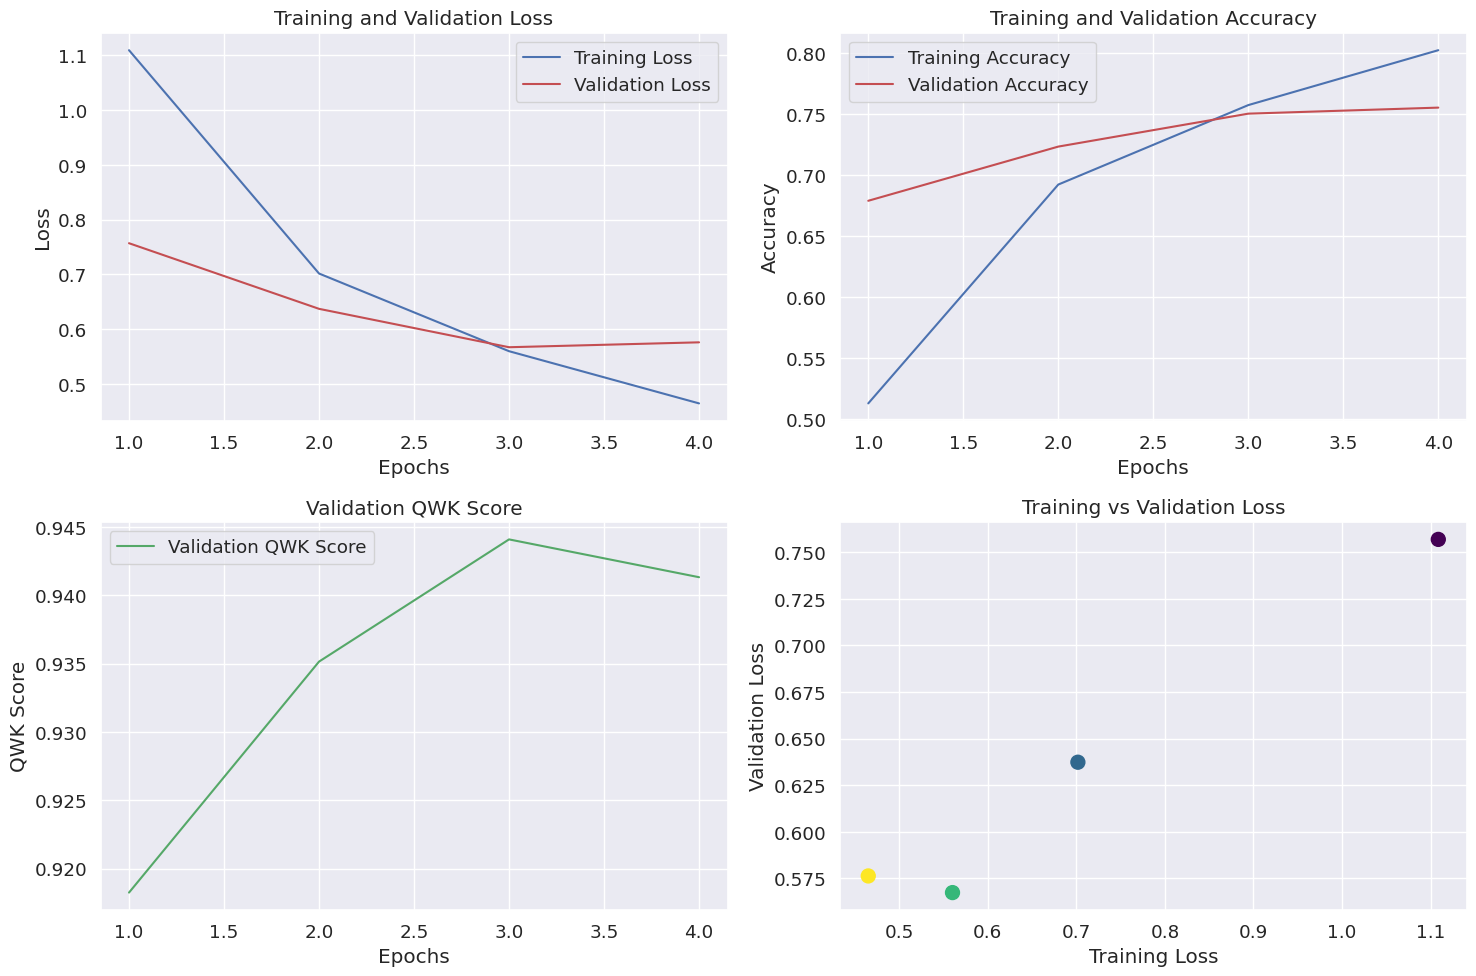

Training metrics visualization saved to 'training_metrics_roberta.png'


In [15]:
# Train the model
trained_model = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    num_epochs,
    device
)

In [16]:
!pip install symspellpy language-tool-python nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 8.7 MB/s eta 0:00:00


In [17]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from symspellpy import SymSpell, Verbosity
import language_tool_python
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Download NLTK data
nltk.download('punkt')

# Initialize spell checker and grammar checker
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = '/usr/local/lib/python3.10/dist-packages/symspellpy/frequency_dictionary_en_82_765.txt'
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
tool = language_tool_python.LanguageTool('en-US')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model and tokenizer
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=6)

# Load the saved state dict and adjust for DataParallel prefix
state_dict = torch.load('/kaggle/working/best_roberta_model.pt', map_location=device, weights_only=True)
adjusted_state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}
model.load_state_dict(adjusted_state_dict)
model.to(device)
model.eval()

# Prediction function
def predict_score(text, model, tokenizer, device):
    encoding = tokenizer(text, max_length=512, padding='max_length', truncation=True, return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).cpu().item()
    return predicted_class + 1

# Improved spell checking function
def list_spelling_errors(text):
    # Common misspellings dictionary - add more as needed
    common_errors = {
        "globbal": "global",
        "hoter": "hotter",
        "activitees": "activities",
        "fosil": "fossil",
        "tree's": "trees",
        "dyoxide": "dioxide",
        "tempature": "temperature",
        "fastly": "quickly",
        "causeing": "causing",
        "see levels": "sea levels",
        "city's": "cities",
        "bares": "bears",
        "disapering": "disappearing",
        "drougts": "droughts",
        "pollushion": "pollution",
        "electricty": "electricity",
        "hole": "whole",
        "there": "their",
        "what": "that",
        "is losing": "are losing",
        "people is": "people are",
        "places is": "places are",
        "gonna": "going to"
    }
    
    contractions = {
        "its": "it's",  # possessive vs contraction check
    }
    
    errors = []
    
    # First check for words in our custom dictionary
    for error, correction in common_errors.items():
        if re.search(r'\b' + re.escape(error) + r'\b', text, re.IGNORECASE):
            errors.append((error, correction))
    
    # Check for contraction errors
    for error, correction in contractions.items():
        if re.search(r'\b' + error + r'\b', text):  # Case-sensitive for contractions
            # Make sure it's not being used correctly (e.g., its vs it's)
            if error == "its" and not re.search(r'\bits\s+\w+\b', text):  # Check if "its" is followed by a word
                errors.append((error, correction))
    
    # Use symspell for additional errors
    words = re.findall(r'\b[\w\'-]+\b', text)
    for word in words:
        # Skip words we've already captured with our custom dictionary
        if any(word.lower() == error.lower() for error, _ in errors):
            continue
            
        # Skip short words, numbers, proper nouns
        if len(word) <= 2 or word.isdigit() or (word[0].isupper() and not word.isupper()):
            continue
            
        # Skip words already in errors list
        if any(word.lower() == error.lower() for error, _ in errors):
            continue
            
        # Use symspell for advanced spell checking
        suggestions = sym_spell.lookup(word.lower(), Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions and suggestions[0].term != word.lower():
            # Only add if the confidence is high enough
            if suggestions[0].distance <= 1:
                errors.append((word, suggestions[0].term))
    
    return errors

# Enhanced grammar checking
def list_grammar_errors(text):
    matches = tool.check(text)
    errors = []
    
    # Additional common grammar patterns to check
    grammar_patterns = [
        (r'\b(is|are|was|were)\s+(\w+ing)\b', r'is/are + verb-ing', 
         "Check verb agreement in progressive tense"),
        (r'\b(they|we|you|I)\s+(\w+[^s])\b', r'subject-verb agreement', 
         "Possible subject-verb agreement error"),
        (r'\btoo much\s+(plural noun)', r'too many', 
         "Consider using 'too many' with countable nouns"),
        (r'\b(more|most)\s+(comparative adjective)', r'double comparison', 
         "Avoid double comparisons"),
        (r'(?<!\w)([A-Z][a-z]+)(?!\w)', r'capitalization', 
         "Check for unnecessary capitalization")
    ]
    
    # Process LanguageTool matches
    for match in matches:
        # Skip spelling errors as they're handled separately
        if match.ruleId not in ["MORFOLOGIK_RULE_EN_US"]:
            errors.append({
                "error": text[match.offset:match.offset + match.errorLength],
                "suggestion": match.replacements[0] if match.replacements else "N/A",
                "message": match.message,
                "context": text[max(0, match.offset-20):min(len(text), match.offset + match.errorLength + 20)]
            })
    
    # Look for additional grammar issues
    sentences = sent_tokenize(text)
    for sentence in sentences:
        # Check for run-on sentences (simple heuristic)
        if len(sentence.split()) > 25 and ',' not in sentence and ';' not in sentence:
            errors.append({
                "error": sentence[:30] + "...",
                "suggestion": "Break into shorter sentences",
                "message": "Possible run-on sentence. Consider breaking this into multiple sentences.",
                "context": sentence[:50] + "..."
            })
            
        # Check for sentence fragments (simple heuristic)
        if len(sentence.split()) < 3 and not any(sentence.endswith(c) for c in ['!', '?']):
            errors.append({
                "error": sentence,
                "suggestion": "Complete the sentence",
                "message": "This may be a sentence fragment. Consider completing the thought.",
                "context": sentence
            })
    
    return errors

# Improved essay polishing
def polish_essay(text):
    polished_text = text
    
    # Fix spacing issues first
    polished_text = re.sub(r'\s{2,}', ' ', polished_text)  # Replace multiple spaces with single space
    polished_text = re.sub(r'\n{2,}', '\n\n', polished_text)  # Normalize paragraph breaks
    
    # Fix spelling errors
    spelling_errors = list_spelling_errors(text)
    for word, correction in spelling_errors:
        polished_text = re.sub(r'\b' + re.escape(word) + r'\b', correction, polished_text, flags=re.IGNORECASE)
    
    # Fix grammar errors using LanguageTool
    matches = tool.check(polished_text)
    polished_text = language_tool_python.utils.correct(polished_text, matches)
    
    # Ensure proper spacing after punctuation
    polished_text = re.sub(r'([.!?])\s*([A-Z])', r'\1 \2', polished_text)
    
    # Ensure paragraphs are properly separated
    polished_text = re.sub(r'([.!?])\s*([A-Z][a-z]+)', r'\1\n\n\2', polished_text)
    
    return polished_text

# Get detailed feedback based on score
def get_score_feedback(score):
    feedback = {
        1: {
            "grade": "Poor",
            "description": "This essay demonstrates significant difficulty in developing and organizing ideas, with major errors in grammar, spelling, and sentence structure that severely impair communication.",
            "strengths": [],
            "weaknesses": [
                "Frequent, major errors in grammar, spelling, and mechanics",
                "Lack of coherent structure and organization",
                "Minimal development of ideas",
                "Limited vocabulary and word choice",
                "Sentence fragments and run-on sentences common"
            ],
            "recommendations": [
                "Focus on mastering basic sentence structure and grammar rules",
                "Practice spelling common words correctly and use a dictionary",
                "Learn to organize ideas into simple paragraphs",
                "Build vocabulary through regular reading",
                "Practice writing complete, clear sentences"
            ]
        },
        2: {
            "grade": "Below Average",
            "description": "This essay shows basic attempts at communication but contains numerous errors in grammar, spelling, and organization that interfere with clarity.",
            "strengths": [
                "Some attempt to address the topic"
            ],
            "weaknesses": [
                "Frequent grammar and spelling errors",
                "Poor paragraph structure and organization",
                "Limited development of ideas",
                "Basic and repetitive vocabulary",
                "Inconsistent verb tense and subject-verb agreement"
            ],
            "recommendations": [
                "Practice identifying subjects and verbs in sentences",
                "Work on paragraph structure with clear topic sentences",
                "Expand vocabulary with more precise word choices",
                "Review basic punctuation rules",
                "Focus on developing ideas with supporting details"
            ]
        },
        3: {
            "grade": "Average",
            "description": "This essay addresses the topic but shows inconsistent organization and development with several errors in grammar and mechanics.",
            "strengths": [
                "Addresses the topic with a basic structure",
                "Some supporting details present"
            ],
            "weaknesses": [
                "Inconsistent organization of ideas",
                "Grammar and spelling errors that occasionally obscure meaning",
                "Limited sentence variety",
                "Imprecise word choice",
                "Weak transitions between ideas"
            ],
            "recommendations": [
                "Practice creating outlines before writing",
                "Vary sentence structure between simple and compound",
                "Add specific examples to support main points",
                "Proofread work for common grammar and spelling errors",
                "Use transitional phrases to connect ideas"
            ]
        },
        4: {
            "grade": "Good",
            "description": "This essay demonstrates adequate organization and development with mostly clear language, though some errors in grammar and mechanics are present.",
            "strengths": [
                "Clear organization with introduction and conclusion",
                "Adequate development of ideas",
                "Generally appropriate word choice",
                "Some sentence variety"
            ],
            "weaknesses": [
                "Occasional grammar and spelling errors",
                "Some imprecise word choices",
                "Limited use of complex sentence structures",
                "Transitions could be more effective",
                "Supporting details sometimes lack specificity"
            ],
            "recommendations": [
                "Practice combining sentences for greater complexity",
                "Expand vocabulary with more precise and varied word choices",
                "Develop stronger transitions between paragraphs",
                "Add more specific supporting details and examples",
                "Proofread for minor grammar and spelling errors"
            ]
        },
        5: {
            "grade": "Very Good",
            "description": "This essay shows strong organization, thorough development, and clear language with only minor errors in grammar and mechanics.",
            "strengths": [
                "Well-organized structure with effective introduction and conclusion",
                "Thorough development of ideas with specific examples",
                "Varied sentence structure",
                "Precise vocabulary and word choice",
                "Few grammar and spelling errors"
            ],
            "weaknesses": [
                "Occasional minor errors in grammar or mechanics",
                "Some transitions could be strengthened",
                "A few instances of imprecise word choice",
                "Limited use of sophisticated rhetorical techniques"
            ],
            "recommendations": [
                "Experiment with more complex sentence structures",
                "Incorporate more sophisticated vocabulary where appropriate",
                "Add more nuanced arguments and counterarguments",
                "Practice using varied rhetorical techniques",
                "Fine-tune grammar and proofreading skills"
            ]
        },
        6: {
            "grade": "Excellent",
            "description": "This essay demonstrates sophisticated organization, insightful development, and precise language with virtually no errors in grammar and mechanics.",
            "strengths": [
                "Sophisticated organization with compelling introduction and conclusion",
                "Insightful development of ideas with specific, relevant examples",
                "Varied and complex sentence structures",
                "Precise and sophisticated vocabulary",
                "Strong command of grammar and mechanics",
                "Effective use of rhetorical techniques"
            ],
            "weaknesses": [
                "Perhaps occasional minor lapses in word choice or style",
                "Very few, if any, grammatical or mechanical errors"
            ],
            "recommendations": [
                "Continue developing your personal writing style",
                "Experiment with more advanced rhetorical techniques",
                "Consider exploring more complex and nuanced arguments",
                "Read sophisticated texts to further expand vocabulary",
                "Share your writing skills by helping others improve"
            ]
        }
    }
    
    return feedback.get(score, {
        "grade": "Unknown",
        "description": "Unable to provide feedback for this score.",
        "strengths": [],
        "weaknesses": [],
        "recommendations": ["Please check the essay scoring system."]
    })

# Main feedback function with improved formatting and detailed score feedback
def evaluate_essay(essay, model, tokenizer, device):
    print("=" * 80)
    print("ESSAY EVALUATION REPORT")
    print("=" * 80)
    
    print("\nORIGINAL ESSAY:")
    print("-" * 80)
    print(essay)
    print("-" * 80)
    
    score = predict_score(essay, model, tokenizer, device)
    feedback = get_score_feedback(score)
    
    print(f"\nPREDICTED SCORE: {score}/6 - {feedback['grade']}")
    print(f"\nASSESSMENT: {feedback['description']}")
    
    print("\nSPELLING ISSUES:")
    print("-" * 80)
    spelling_errors = list_spelling_errors(essay)
    if spelling_errors:
        for i, (error, correction) in enumerate(spelling_errors, 1):
            print(f"{i}. '{error}' → '{correction}'")
    else:
        print("No spelling errors found.")
    
    print("\nGRAMMAR ISSUES:")
    print("-" * 80)
    grammar_errors = list_grammar_errors(essay)
    if grammar_errors:
        for i, error in enumerate(grammar_errors, 1):
            print(f"{i}. Issue: '{error['error']}'")
            print(f"   Suggestion: '{error['suggestion']}'")
            print(f"   Explanation: {error['message']}")
            print(f"   Context: \"...{error['context']}...\"")
            print()
    else:
        print("No grammar issues found.")
    
    print("\nSTRENGTHS:")
    print("-" * 80)
    if feedback["strengths"]:
        for i, strength in enumerate(feedback["strengths"], 1):
            print(f"{i}. {strength}")
    else:
        print("No specific strengths identified.")
    
    print("\nAREAS FOR IMPROVEMENT:")
    print("-" * 80)
    if feedback["weaknesses"]:
        for i, weakness in enumerate(feedback["weaknesses"], 1):
            print(f"{i}. {weakness}")
    else:
        print("No specific weaknesses identified.")
    
    print("\nRECOMMENDATIONS:")
    print("-" * 80)
    if feedback["recommendations"]:
        for i, recommendation in enumerate(feedback["recommendations"], 1):
            print(f"{i}. {recommendation}")
    else:
        print("No specific recommendations available.")
    
    print("\nPOLISHED ESSAY:")
    print("-" * 80)
    polished = polish_essay(essay)
    print(polished)
    print("-" * 80)
    
    # Summary of improvements
    total_errors = len(spelling_errors) + len(grammar_errors)
    print(f"\nSUMMARY: Found {len(spelling_errors)} spelling issues and {len(grammar_errors)} grammar issues.")
    print(f"Total issues identified: {total_errors}")
    
    print("\nNEXT STEPS:")
    print("-" * 80)
    if score <= 3:
        print("Focus on addressing fundamental writing issues before moving to more advanced techniques.")
        print("Consider working with a writing tutor for personalized guidance.")
    elif score <= 5:
        print("Your essay shows good potential. Focus on refining your style and eliminating minor errors.")
        print("Consider peer reviewing to get additional feedback on your writing.")
    else:
        print("Your writing demonstrates excellent skills. Continue to challenge yourself with more complex topics.")
        print("Consider submitting your work for publication or contests to receive expert feedback.")
    
    print("=" * 80)

# Example usage
# sample_essay = "Globbal Warming is Big Problem  Globbal warming is a serious..."
# evaluate_essay(sample_essay, model, tokenizer, device)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
sample_essay1 = """Elections are essential for maintaining a democratic society. They allow citizens to choose their leaders and hold them acountable for their actions. Through voting, people have the power to influence decisions that affect their lives, such as healthcare, education, and economic policies.

Regular elections ensure that leaders remain responsive to public needs. They promote political stabilty by providing a peaceful way to transfer power. Elections also encourage transparency and fairness in governance, as leaders are motivated to perform well to gain public support.

Participating in elections strengthens democracy by giving every citizen a voice. It helps prevent corrpution and misuse of power, ensuring that the government reflects the will of the people. Without free and fair elections, a society risks losing its democratic values and becoming autocratic.

Therefore, elections empower citizens and uphold the principles of democracy. Every vote counts, making it important for people to participate actively in the electoral process to shape a better future."""

evaluate_essay(sample_essay1, model, tokenizer, device)

ESSAY EVALUATION REPORT

ORIGINAL ESSAY:
--------------------------------------------------------------------------------
Elections are essential for maintaining a democratic society. They allow citizens to choose their leaders and hold them acountable for their actions. Through voting, people have the power to influence decisions that affect their lives, such as healthcare, education, and economic policies.

Regular elections ensure that leaders remain responsive to public needs. They promote political stabilty by providing a peaceful way to transfer power. Elections also encourage transparency and fairness in governance, as leaders are motivated to perform well to gain public support.

Participating in elections strengthens democracy by giving every citizen a voice. It helps prevent corrpution and misuse of power, ensuring that the government reflects the will of the people. Without free and fair elections, a society risks losing its democratic values and becoming autocratic.

Theref

In [19]:
sample_essay2 = """Hobbies is gorod for students because they help to relax. If students only study all the time they will get tired and boring. Doing hobbies like playing games or drawing is fun and make students happy. Also it can help them to be more creative and think better.

Sports are also good for students. If a student play football they can make fryends. Also music help them work together. Hobbies can also show what job they will do in the future. If someone like computer they can work with computer later.

Also, hobbies help with timee. Students can do hoomework and hobbies and learn to do both. This will help them be better in life. So hobbies are important for students to be happy and do better."""

evaluate_essay(sample_essay2, model, tokenizer, device)

ESSAY EVALUATION REPORT

ORIGINAL ESSAY:
--------------------------------------------------------------------------------
Hobbies is gorod for students because they help to relax. If students only study all the time they will get tired and boring. Doing hobbies like playing games or drawing is fun and make students happy. Also it can help them to be more creative and think better.

Sports are also good for students. If a student play football they can make fryends. Also music help them work together. Hobbies can also show what job they will do in the future. If someone like computer they can work with computer later.

Also, hobbies help with timee. Students can do hoomework and hobbies and learn to do both. This will help them be better in life. So hobbies are important for students to be happy and do better.
--------------------------------------------------------------------------------

PREDICTED SCORE: 2/6 - Below Average

ASSESSMENT: This essay shows basic attempts at communicatio

In [21]:
sample_essay3 = """First of all, Education teaches the ability to read and write. Reading and writing is the first step in Education. Most information is done by writing. Hence, the lack of writing skill means missing out on a lot of information. Consequently, Education makes people literate.

Above all, Education is extremely important for employment. It certainly is a great opportunity to make a decent living. This is due to the skills of a high paying job that Education provides. Uneducated people are probably at a huge disadvantage when it comes to jobs. It seems like many poor people improve their lives with the help of Education.

Better Communication is yet another role in Education. Education improves and refines the speech of a person. Furthermore, individuals also improve other means of communication with Education.

Education makes an individual a better user of technology. Education certainly provides the technical skills necessary for using technology. Hence, without Education, it would probably be difficult to handle modern machines.

People become more mature with the help of Education. Sophistication enters the life of educated people. Above all, Education teaches the value of discipline to individuals. Educated people also realize the value of time much more. To educated people, time is equal to money.

Finally, Educations enables individuals to express their views efficiently. Educated individuals can explain their opinions in a clear manner. Hence, educated people are quite likely to convince people to their point of view."""

evaluate_essay(sample_essay3, model, tokenizer, device)

ESSAY EVALUATION REPORT

ORIGINAL ESSAY:
--------------------------------------------------------------------------------
First of all, Education teaches the ability to read and write. Reading and writing is the first step in Education. Most information is done by writing. Hence, the lack of writing skill means missing out on a lot of information. Consequently, Education makes people literate.

Above all, Education is extremely important for employment. It certainly is a great opportunity to make a decent living. This is due to the skills of a high paying job that Education provides. Uneducated people are probably at a huge disadvantage when it comes to jobs. It seems like many poor people improve their lives with the help of Education.

Better Communication is yet another role in Education. Education improves and refines the speech of a person. Furthermore, individuals also improve other means of communication with Education.

Education makes an individual a better user of technology.

In [22]:
sample_essay3 = """Reading is a valuable habit that helps people grow mentally and emotionally. It provides knowledge, enhances imagination, and improves communication skills. When a person reads regularly, they gain a better understanding of the world and develop critical thinking skills.

Books open the door to different cultures, ideas, and perspectives. They allow readers to explore new concepts and broaden their worldview. Reading also strengthens vocabulary and improves language skills, making it easier to express thoughts clearly.

Apart from gaining knowledge, reading also helps reduce stress. Immersing oneself in a book provides an escape from daily challenges and promotes relaxation. It boosts concentration and focus, which improves performance in both academic and professional life.

Developing a reading habit from a young age helps build a strong foundation for learning. It encourages curiosity and creativity, making individuals more confident in their ability to solve problems and adapt to new situations.

In conclusion, reading is an essential skill that enriches the mind and improves overall well-being. It allows individuals to expand their knowledge, improve communication, and find comfort in challenging times."""

evaluate_essay(sample_essay3, model, tokenizer, device)

ESSAY EVALUATION REPORT

ORIGINAL ESSAY:
--------------------------------------------------------------------------------
Reading is a valuable habit that helps people grow mentally and emotionally. It provides knowledge, enhances imagination, and improves communication skills. When a person reads regularly, they gain a better understanding of the world and develop critical thinking skills.

Books open the door to different cultures, ideas, and perspectives. They allow readers to explore new concepts and broaden their worldview. Reading also strengthens vocabulary and improves language skills, making it easier to express thoughts clearly.

Apart from gaining knowledge, reading also helps reduce stress. Immersing oneself in a book provides an escape from daily challenges and promotes relaxation. It boosts concentration and focus, which improves performance in both academic and professional life.

Developing a reading habit from a young age helps build a strong foundation for learning. I